In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

In [ ]:
rating_path = '/content/drive/MyDrive/movielens_100k/ml-100k/u.data'
item_path = '/content/drive/MyDrive/movielens_100k/ml-100k/u.item'
user_path = '/content/drive/MyDrive/movielens_100k/ml-100k/u.user'

In [ ]:
df_rating = pd.read_csv(rating_path, sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
df_item = pd.read_csv(item_path, sep='|', encoding='cp1252', header=None,
                      names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown',
                             'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
                             'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                             'Thriller', 'War', 'Western'])
df_user = pd.read_csv(user_path, sep='|', encoding='cp1252', header=None, names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

### 결측치, 중복치 체크

각 데이터프레임마다 간단하게 결측치와 중복치를 체크함

In [ ]:
def check(dataframe):
  print('< 데이터셋 첫 5개 행 >', '', sep='\n')
  print(dataframe.head()) 
  print('='*50, '< 결측치, 중복치 체크 >', '', sep='\n')
  dataframe.info()
  print('', '< 결측치 >', '', sep='\n')
  print(dataframe.isnull().sum())
  print('='*50, '< 고유값 갯수 확인 >', '', sep='\n')
  print(dataframe.nunique())
  print('='*50, '< 중복값 합계 >', '', sep='\n')
  return dataframe.duplicated().sum()

In [ ]:
check(df_rating)

< 데이터셋 첫 5개 행 >

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
< 결측치, 중복치 체크 >

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB

< 결측치 >

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
< 고유값 갯수 확인 >

user_id        943
movie_id      1682
rating           5
timestamp    49282
dtype: int64
< 중복값 합계 >



0

In [ ]:
check(df_item)

< 데이터셋 첫 5개 행 >

   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1         1  ...        0          0    

0

In [ ]:
# release_date, video_release_date, IMDb_URL 컬럼에 결측치가 있는 행이 있지만, 각 컬럼 모두 삭제할 계획이므로 그대로 사용하기로 함
df_item[df_item['release_date'].isnull()]

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### EDA

1. 유저 기준

In [ ]:
# 유저별 영화 평가 횟수, 부여한 별점 평균과 표준편차, 
user_rating_stats = pd.DataFrame({'movie_count' : df_rating.groupby('user_id')['movie_id'].count(),
                             'rating_avg' : df_rating.groupby('user_id')['rating'].mean(),
                             'rating_std' : df_rating.groupby('user_id')['rating'].std()})
user_rating_stats = user_rating_stats.reset_index()

user_rating_stats

,user_id,movie_count,rating_avg,rating_std
0,1,272,3.610294,1.263585
1,2,62,3.709677,1.030472
2,3,54,2.796296,1.219026
3,4,24,4.333333,0.916831
4,5,175,2.874286,1.362963
...,...,...,...,...
938,939,49,4.265306,0.974156
939,940,107,3.457944,1.012007
940,941,22,4.045455,0.898532
941,942,79,4.265823,0.763072


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


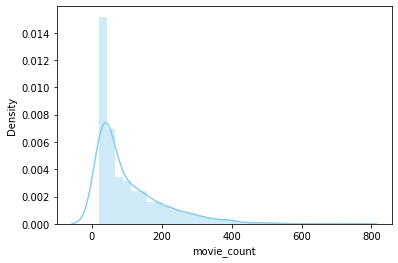

In [ ]:
# 유저별 평가한 영화 횟수 차트로 확인
sns.distplot(user_rating_stats['movie_count'], color='skyblue', label='Movie_count')

In [ ]:
# 유저별 평가한 영화 횟수 내림차순 정렬 확인
user_rating_stats.sort_values(by='movie_count',ascending=False)

,user_id,movie_count,rating_avg,rating_std
404,405,737,1.834464,1.345183
654,655,685,2.908029,0.732701
12,13,636,3.097484,1.416414
449,450,540,3.864815,0.862679
275,276,518,3.465251,1.017140
...,...,...,...,...
684,685,20,2.050000,0.759155
474,475,20,3.600000,1.353358
35,36,20,3.800000,1.281447
731,732,20,3.700000,1.380313


많은 영화를 평가한 유저의 평점이 추후 모델링에 편향으로 작용할 수 있는지, 추후 추천 모델링에서 고려할 필요가 있음(정규화 등)

In [ ]:
# 유저별 평점 부여 횟수 확인
user_rating_cnt = pd.DataFrame({'count' : df_rating.groupby(['user_id', 'rating']).size()})
user_rating_cnt = user_rating_cnt.reset_index()
user_rating_cnt

,user_id,rating,count
0,1,1,25
1,1,2,28
2,1,3,56
3,1,4,82
4,1,5,81
...,...,...,...
4418,943,1,17
4419,943,2,27
4420,943,3,28
4421,943,4,62


In [ ]:
# 100번 유저의 평점별 부여 횟수 확인
user_rating_cnt[user_rating_cnt['user_id'] == 100]

,user_id,rating,count
467,100,1,6
468,100,2,9
469,100,3,22
470,100,4,19
471,100,5,3


2. 영화 기준

In [ ]:
movie_rating_stats = pd.DataFrame({'num_users' : df_rating.groupby('movie_id')['user_id'].count(),
                             'rating_avg' : df_rating.groupby('movie_id')['rating'].mean(),
                             'rating_std' : df_rating.groupby('movie_id')['rating'].std()})
movie_rating_stats = movie_rating_stats.reset_index()

movie_rating_stats

,movie_id,num_users,rating_avg,rating_std
0,1,452,3.878319,0.927897
1,2,131,3.206107,0.966497
2,3,90,3.033333,1.212760
3,4,209,3.550239,0.965069
4,5,86,3.302326,0.946446
...,...,...,...,...
1677,1678,1,1.000000,NaN
1678,1679,1,3.000000,NaN
1679,1680,1,2.000000,NaN
1680,1681,1,3.000000,NaN


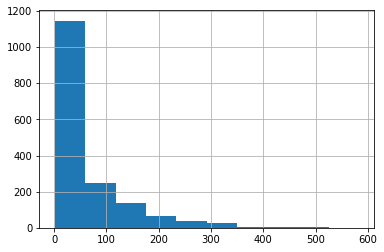

In [ ]:
movie_rating_stats['num_users'].hist()

In [ ]:
# 영화를 평가한 유저의 수 통계, 25% 분포에 6명 확인
movie_rating_stats.describe()

,movie_id,num_users,rating_avg,rating_std
count,1682.000000,1682.000000,1682.000000,1541.000000
mean,841.500000,59.453032,3.076045,1.056714
std,485.695893,80.383846,0.781662,0.292709
min,1.000000,1.000000,1.000000,0.000000
25%,421.250000,6.000000,2.659600,0.915758
50%,841.500000,27.000000,3.161528,1.034211
75%,1261.750000,80.000000,3.653428,1.169401
max,1682.000000,583.000000,5.000000,2.828427


In [ ]:
movie_rating_stats['movie_id'][movie_rating_stats.num_users < 5].count()

333

평가한 유저의 수가 적은, 5명 이하의 경우 해당 영화의 평점을 반영할 것인지, 아니면 유의미하지 않다고 판단하여 제거할 것인지 모델링 시 판단이 필요

In [ ]:
# 전체 영화 평균 평점, 표준 편차 확인
df_rating.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


전체 영화의 평균 평점 : 3.53점 \
전체 평점의 표준 편차 : 1.12점 확인

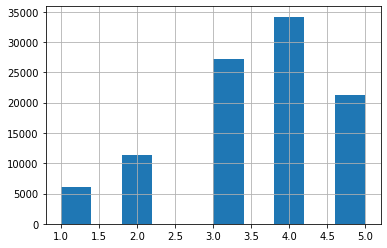

In [ ]:
# 영화 평점의 분포 확인
df_rating['rating'].hist()

대체적으로 유저들이 3~4점 사이의 평점을 예측한 것을 확인할 수 있음

In [ ]:
df_rating_overall = df_rating.copy()
df_rating_overall = pd.merge(df_rating, df_item, how='left', on='movie_id')

In [ ]:
# movie_id 기준 df_item 내용 병합 확인
df_rating_overall

,user_id,movie_id,rating,timestamp,title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,874795795,Sliver (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,0,...,0,0,0,0,0,0,0,1,0,0
99998,13,225,2,882399156,101 Dalmatians (1996),27-Nov-1996,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 데이터 분석에 필요없는 video_release_date, IMDb_URL컬럼 삭제
df_rating_overall.drop(labels=['timestamp', 'release_date', 'video_release_date', 'IMDb_URL'], axis=1, inplace=True)

In [ ]:
df_rating_overall.head()

,user_id,movie_id,rating,title,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,Kolya (1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**추천시스템 모델링** \

추천시스템 : 사용자 id와 영화 id의 두 개의 카테고리 입력과 평점 출력을 가지는 예측 시스템


## 콘텐츠 기반 필터링(CB)

df_item의 각 영화 장르를 활용해서 만들어보기로 함(영화에 따라 장르는 복수체크되어 있음)

In [ ]:
df_item.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# title로 인덱스 설정, 벡터화에 필요 없는 컬럼 삭제
df_item_vec = df_item.copy().sort_values(by=['movie_id'], ascending=True)
df_item_vec.set_index('title', inplace=True)
df_item_vec.drop(labels=[ 'movie_id', 'release_date', 'video_release_date', 'IMDb_URL'], axis=1, inplace=True)

In [ ]:
df_item_vec

,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mat' i syn (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
B. Monkey (1998),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
Sliding Doors (1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
# 장르 정보를 벡터로 하여 아이템 - 아이템 간 코사인 유사도 계산
movie_genre_sim = cosine_similarity(df_item_vec, df_item_vec)

In [ ]:
movie_genre_sim = pd.DataFrame(data=movie_genre_sim, index=df_item_vec.index, columns=df_item_vec.index)
movie_genre_sim

title,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000
GoldenEye (1995),0.000000,1.000000,0.577350,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.816497,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.00000,0.000000
Four Rooms (1995),0.000000,0.577350,1.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.00000,0.000000
Get Shorty (1995),0.333333,0.333333,0.000000,1.000000,0.333333,0.577350,0.408248,0.666667,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.000000,0.408248,0.57735,0.577350
Copycat (1995),0.000000,0.333333,0.577350,0.333333,1.000000,0.577350,0.408248,0.333333,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.408248,0.408248,0.00000,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mat' i syn (1997),0.000000,0.000000,0.000000,0.577350,0.577350,1.000000,0.707107,0.577350,1.000000,0.707107,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.707107,0.00000,1.000000
B. Monkey (1998),0.000000,0.408248,0.707107,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.00000,0.000000
Sliding Doors (1998),0.000000,0.000000,0.000000,0.408248,0.408248,0.707107,0.500000,0.408248,0.707107,0.500000,...,0.000000,0.707107,0.707107,0.707107,0.707107,0.707107,0.500000,1.000000,0.00000,0.707107


In [ ]:
# 비슷한 장르의 상위 5개 영화 목록 조회
def rec_movie(df, title):
  return df[title].sort_values(ascending=False)[1:11]

In [ ]:
rec_movie(movie_genre_sim, "Get Shorty (1995)")

title
Faster Pussycat! Kill! Kill! (1965)    1.000000
Best Men (1997)                        0.866025
Deconstructing Harry (1997)            0.816497
Romper Stomper (1992)                  0.816497
Caro Diario (Dear Diary) (1994)        0.816497
Unstrung Heroes (1995)                 0.816497
Beverly Hills Ninja (1997)             0.816497
Month by the Lake, A (1995)            0.816497
Salut cousin! (1996)                   0.816497
Johnny 100 Pesos (1993)                0.816497
Name: Get Shorty (1995), dtype: float64

위의 CB의 경우, 장르 특성 하나만을 사용했기 때문에 코사인 유사도값이 같은 경우가 너무 많음 \
정보를 필터링하는 효과가 미미하다고 볼 수 있음

## 유저 평점에 의한 아이템 기반 협업 필터링(CF)

메모리 기반의 접근 방식으로, 유저가 특정 아이템에 대해 내린 평점을 취합하여(평균) 피봇 테이블을 생성, \
이후 아이템 - 아이템 간의 유사도를 측정하여 추정\

`※ 이 경우 평점이 없거나 새로운 아이템에 대한 추정 및 추천이 불가능한 coldstart 문제 발생`

우선 인덱스가 영화 id, 컬럼이 사용자 id인 피봇테이블을 생성한다. (item-item 기반)

In [ ]:
df_rating_overall.head()

,user_id,movie_id,rating,title,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,Kolya (1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train, df_test = train_test_split(df_rating_overall[['user_id', 'movie_id', 'rating', 'title']], test_size=0.2, random_state=42)

print(df_train.shape)
print(df_test.shape)

(80000, 4)
(20000, 4)


In [ ]:
df_pivot = pd.pivot_table(data=df_train, values='rating', index='user_id', columns='movie_id', aggfunc='mean', fill_value=0)
df_pivot

movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,3,4,0,3,0,4,0,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 아이템 기반 협업 필터링을 위해 transpose
df_pivot = df_pivot.transpose()

In [ ]:
def cossim_matrix(a, b):
  cossim_values = cosine_similarity(a, b)
  df_cossim = pd.DataFrame(data=cossim_values, index=a.index, columns=b.index)

  return df_cossim

In [ ]:
# 아이템 - 아이템 간의 코사인 유사도 계산
# 평균 평점을 기반으로 아이템-아이템 간 유사도
df_movie_sim = cossim_matrix(df_pivot, df_pivot)
df_movie_sim

movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.311393,0.253690,0.350312,0.214229,0.081377,0.520601,0.376806,0.395321,0.208464,...,0.0,0.0,0.0,0.000000,0.040426,0.000000,0.0,0.0,0.0,0.000000
2,0.311393,1.000000,0.216764,0.383544,0.304612,0.000000,0.297186,0.308952,0.222845,0.121722,...,0.0,0.0,0.0,0.062446,0.000000,0.000000,0.0,0.0,0.0,0.088312
3,0.253690,0.216764,1.000000,0.261066,0.141570,0.058716,0.271301,0.167238,0.224092,0.120622,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.350312,0.383544,0.261066,1.000000,0.270286,0.061803,0.366117,0.370546,0.265128,0.190169,...,0.0,0.0,0.0,0.043872,0.000000,0.103406,0.0,0.0,0.0,0.062044
5,0.214229,0.304612,0.141570,0.270286,1.000000,0.017833,0.246926,0.196619,0.199997,0.036237,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,0.000000,0.000000,0.000000,0.103406,0.000000,0.000000,0.000000,0.000000,0.064018,0.086747,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000


In [ ]:
# train data의 movie_id 1635개, user_id 943개
grouped_userId = df_train.groupby('user_id')
df_item_pred = pd.DataFrame(index=list(grouped_userId.indices.keys()), columns=df_pivot.index)

df_item_pred

movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for user_id, group in tqdm(grouped_userId):
  # 유저가 평점을 매긴 movie_id * 전체 movie_id
  user_sim = df_movie_sim.loc[group['movie_id']]
  # 유저가 평점을 매긴 movie_id * 1
  user_rating = group['rating']
  # 전체 movie_id * 1
  sim_sum = user_sim.sum(axis=0)

  # user_id의 전체 rating predictions (1635 * 1)
  pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1)
  df_item_pred.loc[user_id] = pred_ratings

100%|██████████| 943/943 [00:08<00:00, 116.85it/s]


In [ ]:
for user_id, group in grouped_userId :
  print(user_id,'\n', group)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
91336      784       346       4   
96527      784       340       3   
70804      784       310       4   
51340      784       269       5   
87034      784       344       4   
52013      784       307       4   
89035      784       332       4   
69882      784       272       4   
59058      784       286       3   
71071      784       751       4   
80941      784       304       4   
77437      784       258       5   
60748      784       270       3   
55627      784      1038       3   
59145      784       271       3   
52482      784       678       4   
76018      784       315       4   
73596      784       333       4   
58026      784       328       3   
95669      784       327       4   
76674      784       323       4   
89709      784       299       3   

                                                title  
62659                               Red Corner (1997)  
86967                                  Amistad (1997)  
637

In [ ]:
pred_ratings

movie_id
1       3.429828
2       3.405982
3       3.391791
4       3.447051
5       3.394639
          ...   
1676    2.543351
1678    0.000000
1679    0.000000
1680    0.000000
1681    3.043722
Length: 1653, dtype: float64

In [ ]:
# 아이템 - 아이템 유사도 기반으로 전체 평점을 매긴 데이터프레임
df_item_pred.head(15)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1670,1671,1672,1673,1676,1678,1679,1680,1681
1,3.775684,3.672187,3.726879,3.777769,3.621261,3.872582,3.796882,3.785137,3.839051,3.856086,...,1.792409,1.792409,0.554419,3.422539,2.667732,2.567201,1.346677,1.346677,1.346677,3.38346
2,3.690095,3.460458,3.432664,3.612252,3.393049,3.365684,3.677807,3.635953,3.683955,3.599865,...,2.297985,2.297985,1.476957,2.185541,1.671842,1.8632,2.01972,2.01972,2.01972,1.91345
3,2.495472,2.395671,2.362445,2.480995,2.318657,2.039104,2.532469,2.4683,2.51056,2.38626,...,1.960426,1.960426,1.844095,1.557104,0.577465,1.793905,2.268316,2.268316,2.268316,0.977372
4,3.496073,3.151161,3.078159,3.350684,3.10827,2.29261,3.53136,3.37241,3.418274,2.922375,...,2.06894,2.06894,2.313868,1.458009,0.995289,1.269404,2.786999,2.786999,2.786999,1.139126
5,3.043606,2.926717,2.913043,2.986703,2.849671,2.747344,3.060383,2.988354,2.98827,3.032739,...,0.308141,0.308141,0.108643,2.419588,1.609277,1.886279,0.02957,0.02957,0.02957,2.570726
6,3.509882,3.468912,3.419852,3.597981,3.434983,3.549081,3.513769,3.612698,3.565829,3.60641,...,2.086004,2.086004,0.656558,2.889171,2.579271,2.332461,1.384358,1.384358,1.384358,2.977995
7,3.989677,3.930343,3.865144,4.010346,3.882675,3.931843,3.975579,4.02437,4.017643,4.001671,...,1.325235,1.325235,0.976821,3.553345,3.439084,3.076363,1.400778,1.400778,1.400778,3.675665
8,3.78779,3.774508,3.555868,3.852678,3.685493,3.05001,3.79315,3.83909,3.767995,3.644599,...,1.218514,1.218514,0.470514,2.656963,1.412142,2.250829,0.478786,0.478786,0.478786,2.905393
9,3.425376,3.111276,2.953738,3.294121,3.010607,2.260743,3.48508,3.283906,3.31195,2.982413,...,0.916197,0.916197,0.41951,1.099683,0.682621,1.223109,0.955457,0.955457,0.955457,1.059815
10,4.120016,4.076628,3.977252,4.120502,4.042859,3.89952,4.11283,4.133743,4.113938,4.068914,...,1.022352,1.022352,0.807527,3.346129,3.108444,2.979706,1.259286,1.259286,1.259286,3.449603


In [ ]:
def evaluate(df_test, df_pred):
  groupby_movie_id = df_test.groupby(by='movie_id')
  groupby_user_id = df_test.groupby(by='user_id')

  intersection_movie_id = sorted(list(set(list(df_pred.columns)).intersection(set(list(groupby_movie_id.indices.keys())))))
  intersection_user_id = sorted(list(set(list(df_pred.index)).intersection(set(list(groupby_user_id.indices.keys())))))

  print(len(intersection_movie_id))
  print(len(intersection_user_id))

  df_evaluate = df_pred.loc[intersection_user_id][intersection_movie_id]

  # test part
  grouped = df_test.groupby(by='user_id')
  result_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
    if userId in intersection_user_id:
      pred_ratings = df_evaluate.loc[userId][df_evaluate.loc[userId].index.intersection(list(group['movie_id'].values))]
      pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movie_id','rating':'pred_rating'})
      actual_ratings = group[['rating', 'movie_id']].rename(columns={'rating':'actual_rating'})

      df_final = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movie_id'])
      df_final = df_final.reindex(columns=['movie_id', 'actual_rating', 'pred_rating'])

  return df_final

In [ ]:
result_df = evaluate(df_test, df_item_pred)

1382
940


100%|██████████| 940/940 [00:03<00:00, 245.75it/s]


In [ ]:
result_df.head()

,movie_id,actual_rating,pred_rating
0,672,5,3.387437
1,794,3,3.248933
2,732,4,3.369577
3,281,4,3.363619
4,79,5,3.439577


In [ ]:
print(f"RMSE : {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

RMSE : 1.1582001608633619
